In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time



In [2]:
from helpe_funcs import *

## I. Data import ##

### I.a) Import positions ###

In [3]:
csv_file_name = 'sensor_positions.csv'
coords = []
IDs = []

with open('./data/' + csv_file_name, 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        coord = (float(row[0].split(' ')[0].replace('(', '')), 
                 float(row[0].split(' ')[1].replace(')', '')) )
        coords.append(coord)
        
        IDs.append(row[1])

stations_df = pd.DataFrame(data={'coords': coords, 'IDs': IDs})
stations_df.drop_duplicates(subset='IDs', keep='first', inplace=True)
stations_df.set_index('IDs', inplace=True)

IDs = list(stations_df.index)

del csv_file_name, coords, csv_reader, read_obj, row

### I.b) Form groups based on distance between stations ###

In [4]:
groups = make_groups(IDs, stations_df)
stations_df.insert(loc=1, column='grps', value=groups['grp'])

del groups

create groups of sensors based on distance between them


### I.c) Import sound pressure values ###

In [5]:
dir_path = './data'
csv_file_names = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.find('data.csv') != -1:
            csv_file_names.append(path)
            
del path, dir_path

Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [6]:
list_df = []
sensor_names = []


for filename in csv_file_names:
    df = pd.read_csv('./data/' + filename, index_col=None, header=0)
    df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
    sensor_names.append(filename[12:16]);
    list_df.append(df);

list_len = [len(df) for df in list_df];

del filename, csv_file_names

### I.d) Get rid of duplicates and fill in missing timestamps ###
-> data is transformed into uniformely sampled data with `np.nan()` in place of missing values
-> start date is 2022.02.20 00:00:00, stop date is 2022.03.05 00:00:00
-> all data is organised into a DataFrame, columns=Sensor IDs, index=Timestamps

In [7]:
start_time = datetime.strptime('2022.02.20 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.03.05 00:00:00', '%Y.%m.%d %H:%M:%S')
tindex = pd.date_range(start_time, end_time, freq='1min')
data_label='dt_sound_level_dB'

df_data_incomplete = pd.DataFrame(index=tindex, columns=sensor_names)

list_df_incomplete = []

idx = 0
for df in list_df:
    # get rid of redundant datapoints
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]
    df.drop_duplicates(subset='Time', keep='first', inplace=True)
    
    # index data by Time
    df.index = pd.to_datetime(df['Time'])
    df.drop(columns=['Time'], inplace=True)
    df = df.reindex(tindex)
    
    list_df_incomplete.append(df)
    df_data_incomplete[sensor_names[idx]] = df[data_label]
    idx = idx + 1

del df

## II. Interpolation ##

### II.a) Simple interpolation ###
-> 'nearest'
-> 'linear'

In [8]:
#interpolate data using 'nearest' method
list_df_other = []
list_df_linear = []
list_df_nearest = []


temp_df = df_data_incomplete.interpolate(method='nearest')
df_data_nearest = temp_df.interpolate(limit_area=None, method='backfill')
  
temp_df = df_data_incomplete.interpolate(method='linear')
df_data_linear = temp_df.interpolate(limit_area=None, method='backfill') 
df_data_linear.apply(lambda x: np.round(x, 1), 1);


### II.b) Attempts on advanced interpolation ###

#### II.b.1) Raw data separation and filtering ####
-> data is separated into 2 groups: workdays(`df_work_...`), weekenddays(`df_end_...`)

In [9]:
day_str = datetime.strptime('2023.05.01 00:00:00', '%Y.%m.%d %H:%M:%S')
day_stp = datetime.strptime('2023.05.01 23:59:59', '%Y.%m.%d %H:%M:%S')
daindex = pd.date_range(day_str, day_stp, freq='1min')

df_workd_mean = pd.DataFrame(index=daindex, columns=sensor_names)
df_endd_mean = pd.DataFrame(index=daindex, columns=sensor_names)

df_work_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week < 5].copy()
df_end_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week > 4].copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    
    df_workd_mean.loc[moment] = df_work_all.iloc[idxs_work].mean()
    df_endd_mean.loc[moment] = df_end_all.iloc[idxs_end].mean()

del day_stp, day_str, idxs_work, idxs_end


#### II.b.2) Mean-day model interpolation ####
-> data is filtered (meaned) to create average workday and average weekend day

In [10]:
df_mean_ww = df_work_all.copy()
df_mean_we = df_end_all.copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    
    df_mean_ww.iloc[idxs_work] = df_workd_mean.loc[moment]
    df_mean_we.iloc[idxs_end] = df_endd_mean.loc[moment]
    
df_mean = pd.concat([df_mean_we, df_mean_ww], axis=0)
df_mean.sort_index(inplace=True)

del df_mean_ww, df_mean_we, idxs_end, idxs_work

#### II.b.3) Neighbor data interpolation ####
- Missing data is filled with data of neighboring sensors
-- 1) calculate correlation coefficients
--- a) for raw data
--- b) for average day
-- 2) calculate linear approximation (no offset)
-- 3) approximate missing data (only if raw data available)

In [12]:
# 1a)
sensor_names_set = set(sensor_names);

tdata = [[] for _ in range(len(IDs))]
stations_df['grp_corrs_i']= tdata
icors = []
ixx = []
iscorr = []

for id in sensor_names:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(sensor_names_set & group)
        # 3) extract data
        group_df = df_data_incomplete[group]
        single_df = df_data_incomplete[id]
        stations_df['grps'][id] = group
        corrs = []
        icors = []
        for fid in group:
            # 5) determine lag for precision improvement
            temp = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(temp))
            itemp = ttemp.index(max(ttemp))
            ttuple = (temp[itemp], itemp-10, fid)
            corrs.append(ttuple)
            icors.append(max(temp))
            
        stations_df['grp_corrs_i'][id] = corrs
        ixx.append(id)
        iscorr.append(icors)
        #print(corrs)

del temp, ttemp, itemp, ttuple, icors, group, corrs


In [13]:
# 1b)
sensor_names_set = set(sensor_names);

tdata = [[] for _ in range(len(IDs))]
stations_df['grp_corrs_m']= tdata

mcors = []
mxx = []

mscors = []
msxx = []

for id in sensor_names:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(sensor_names_set & group)
        # 3) extract data
        group_df = df_mean[group]
        single_df = df_mean[id]
        stations_df['grps'][id] = group
        corrs = []
        mcors = []
        for fid in group:
            # 5) determine lag for precision improvement
            temp = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(temp))
            itemp = ttemp.index(max(ttemp))
            ttuple = (temp[itemp], itemp-10, fid)
            mcors.append(max(temp))
            corrs.append(ttuple)
        stations_df['grp_corrs_m'][id] = corrs
        mxx.append(id)
        mscors.append(mcors)
        #print(corrs)

del temp, ttemp, itemp, ttuple, mcors, group, corrs

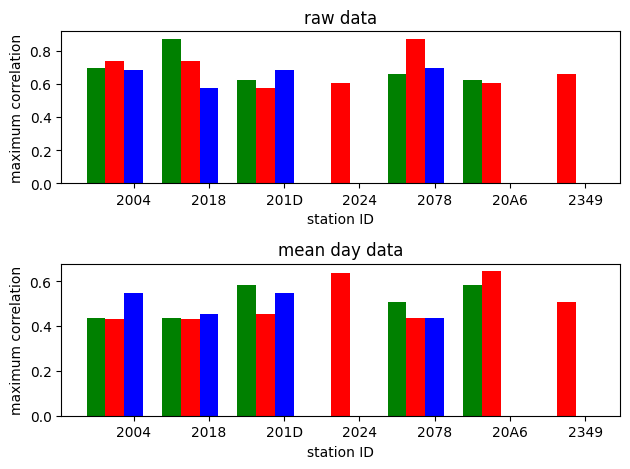

In [14]:
fig, ax = plt.subplots(2,1)

arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(iscorr)):
    arr0.append(iscorr[i][0])
    if len(iscorr[i]) > 1:
        arr1.append(iscorr[i][1])
    else:
        arr1.append(0)
        
    if len(iscorr[i]) > 2:
        arr2.append(iscorr[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(ixx))

ax[0].set_xlabel('station ID')
ax[0].set_ylabel('maximum correlation')
ax[0].bar(X, arr0, color='r', width = 0.25)
ax[0].bar(X-.25, arr1, color='g', width = 0.25)
ax[0].bar(X+.25, arr2, color='b', width = 0.25, tick_label=ixx)
ax[0].set_title('raw data')



arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(mscors)):
    arr0.append(mscors[i][0])
    if len(mscors[i]) > 1:
        arr1.append(mscors[i][1])
    else:
        arr1.append(0)
        
    if len(mscors[i]) > 2:
        arr2.append(mscors[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(mxx))

ax[1].set_xlabel('station ID')
ax[1].set_ylabel('maximum correlation')
ax[1].bar(X, arr0, color='r', width = 0.25, tick_label=mxx)
ax[1].bar(X - .25, arr1, color='g', width = 0.25, tick_label=mxx)
ax[1].bar(X + .25, arr2, color='b', width = 0.25, tick_label=mxx)
ax[1].set_title('mean day data')




fig.tight_layout()
plt.show()

del X, arr0, arr1, arr2

Raw data clearly shows higher correlation than the averaged one - raw data will be used to fill missing values.

In [17]:
# 2) calculate betas
def calculate_linear_regression(df_data1, df_data2, lag):
    df_indata = pd.DataFrame(columns=['d1', 'd2'], index=df_data1.index)
    df_indata['d1'] = df_data1
    df_indata['d2'] = df_data2.shift(periods=lag)
    tcov = df_indata.cov(min_periods = 5)
    tcov = df_indata.cov(min_periods = 5)
    tvar = df_indata['d2'].var()
    return tcov/tvar
    
xx = []
betas = []    
    
sensor_names_set = set(sensor_names);

tdata = [[] for _ in range(len(IDs))]
stations_df['grp_linear']= tdata

for id in sensor_names:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_corrs_i']
        single_df = df_data_incomplete[id]
        beta = []
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            fid = ftup[2]
            lag = ftup[1]
            group_df = df_data_incomplete[fid]
            temp = calculate_linear_regression(single_df, group_df, lag)
            ttuple = (temp, lag, fid)
            beta.append(ttuple)
            
        stations_df['grp_corrs_i'][id] = beta
        xx.append(id)
        betas.append(beta)
        
del temp, ttuple, ftup, fid, lag, xx, beta, betas

In [ ]:
# 3) 

#### II.b.4) Determine resampling period ####

Determine resampling period based on rmse=f(Tresample)

1) for mean interpolation
2) for linear interpolation

The data is downsampled for sampling periods of [1, 2, 5, 10, 15, 20, 30, 60] minutes and rmse is calculated to provide an esimate for information loss

1) no interpolation - simple resampling

In [ ]:
list_rmses = []
resample_pers = [1, 2, 5, 10, 15, 20, 30, 60]
fig, ax = plt.subplots(2,2)

In [ ]:
no_interpolation_res = evaluate_resample(df_data_incomplete, df_data_incomplete) 

list_rmses.append([no_interpolation_res[0].mean(),
                   no_interpolation_res[1].mean(),
                   no_interpolation_res[2].mean()])

ax[0, 0] = init_ax_resamp(ax[0, 0], resample_pers, list_rmses)
ax[0, 0].set_title('No interpolation,  only downsampling')    

1) mean interpolation - average days

In [ ]:
mean_interpolation_res = evaluate_resample(df_data_incomplete, df_mean)
 

list_rmses.append([mean_interpolation_res[0].mean(),
                   mean_interpolation_res[1].mean(),
                   mean_interpolation_res[2].mean()])

ax[0, 1] = init_ax_resamp(ax[0, 1], resample_pers, list_rmses)
ax[0, 1].set_title('Mean day interpolation')

In [ ]:
ax[1, 0] = init_ax_resamp(ax[1, 0], resample_pers, list_rmses)
ax[1, 1] = init_ax_resamp(ax[1, 1], resample_pers, list_rmses)


ax[1, 0].set_title('Region 3')
ax[1, 1].set_title('Region 4')

fig.tight_layout()
plt.show()

In [ ]:
d = no_interpolation_res[0].copy()

# TESTING #

In [ ]:
id = sensor_names[0]
group = stations_df.loc[id]['grps']
colnames = df_data_incomplete.columns



In [ ]:
df_data1 = df_data_incomplete[id]
df_data2 = df_data_incomplete[group[0]]
df_indata = pd.DataFrame(columns=['d1', 'd2'], index=df_data1.index)
df_indata['d1'] = df_data1

In [ ]:
len(mscors)

In [ ]:
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

In [ ]:
len(mxx)

In [ ]:
l = np.array()
l.append(1)
l.append(2)


In [ ]:
for df in [ensemble1, ensemble2]:
    mean_list = []
    median_list = []
    std_list = []

    for size in sample_sizes:
        sample_size = int(size * len(df))
        sample = df.sample(n=sample_size, replace=False)
        mean_list.append(np.mean(sample['mean']))
        median_list.append(np.median(sample['mean']))
        std_list.append(np.std(sample['mean']))

    means.append(mean_list)
    medians.append(median_list)
    stds.append(std_list)

fig, ax = plt.subplots(3, figsize=(10, 10))

for axis in range(3):
    for i, name in enumerate(['ensemble1', 'ensemble2']):
        ax[axis].plot(sample_sizes, stat_data[axis][i], label=name)

    ax[axis].set_title(stats[axis])
    ax[axis].set_xlabel('sample percentage')

fig.tight_layout()
plt.legend()
plt.show()